torch.Size([1, 36, 3, 241, 425])
Matched Point:  (4, 11)
(1674, 1674)
Matched Point 2:  (tensor(12), tensor(1))   tensor(0.7223)


/tmp/ipykernel_176157/3297214784.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v1 = torch.tensor(f1[:,point[0], point[1]]).view(1,-1, 1)
/tmp/ipykernel_176157/3297214784.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v2 = torch.tensor(f2[:,xstart:xend, ystart:yend]).permute(1,2,0)


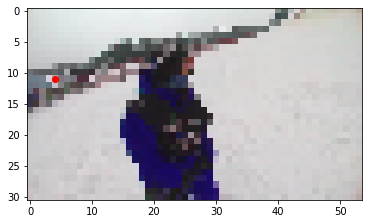

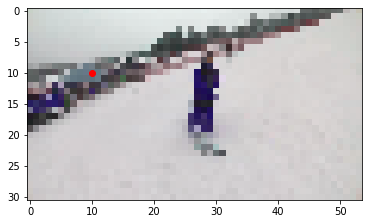

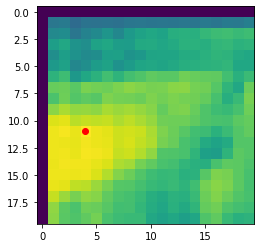

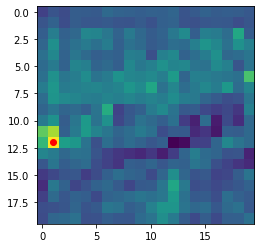

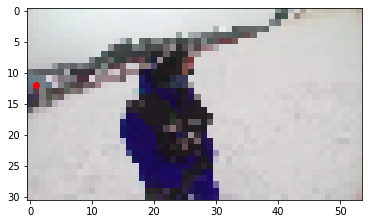

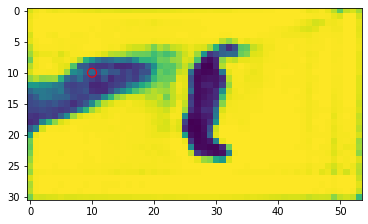

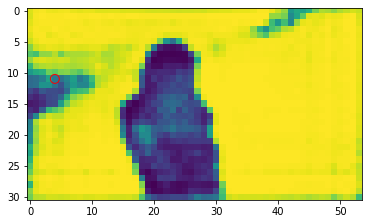

In [129]:
!pip install torchvision

%matplotlib inline
import matplotlib.pyplot as plt
import torch
import cv2
import torch.nn.functional as F
import torchvision

def denormalize(img, mean, scale):
    img = img.permute(1,2,0)
    img = img * torch.tensor(scale) + torch.tensor(mean)
    img = img.cpu().numpy()
    img = np.asarray(img[:,:,::-1]*255, np.uint8)
    return img 

idx = 17 # frame I am debugging
point = (10, 10) # exact point debugging
import numpy as np
img = torch.tensor(np.load('qry.npy'))

############################################ Use resnet50 features ######################
import torchvision.models as models
model = models.resnet50(pretrained=True).cuda()
modules = [x for x in model.named_children()]
x = img.squeeze(0).cuda()
for name, mod in modules:
    if name == 'layer3':
        break
    x = mod(x)
resnet50_feats = x

################################# Read Images and Peaks ###############
next_idx = 10
mean = [0.485, 0.456, 0.406]                                                                                                                                                                               
std = [0.229, 0.224, 0.225]
img1 = cv2.resize(denormalize(img[0,idx], mean, std), (54, 31))
img2 = cv2.resize(denormalize(img[0,idx+next_idx], mean, std), (54, 31))
xpeaks = np.load('xpeaks.npy')
ypeaks = np.load('ypeaks.npy')
print(img.shape)

################ Print Image 1 with max correlated point ###################
plt.figure(1)
plt.imshow(img2)
plt.scatter((xpeaks[point[0], point[1]]), (ypeaks[point[0], point[1]]), c='r')
print('Matched Point: ', (xpeaks[point[0], point[1]], ypeaks[point[0], point[1]]))

################ Print Image 2 with query point ###################
plt.figure(2)
plt.imshow(img1)
plt.scatter((point[1]), (point[0]), c='r')

##################### Compute Window ###########################
indent = 10
xstart = point[0] - indent if point[0] - indent > 0 else 0
xend = point[0] + indent if point[0] + indent < 54 else 53
ystart = point[1] - indent if point[1] - indent > 0 else 0
yend = point[1] + indent if point[1] + indent < 31 else 30

################ Print Correlation with matched point ###################
correlation = np.load('correlation.npy')
print(correlation.shape)
plt.figure(3)
plt.imshow(correlation[:,point[0]*54+point[1]].reshape(31,54)[xstart:xend, ystart:yend])
#import pdb; pdb.set_trace()
plt.scatter((xpeaks[point[0], point[1]]-ystart), (ypeaks[point[0], point[1]]-xstart), c='r')

#f1 = np.load('f1.npy')[:,0].reshape((512, 31, 54))
#f2 = np.load('f2.npy')[:,:,0].reshape((512, 31, 54))
f1 = resnet50_feats[idx].cpu()
f2 = resnet50_feats[idx+next_idx].cpu()

#print(f1.shape, ' ', f2.shape)
v1 = torch.tensor(f1[:,point[0], point[1]]).view(1,-1, 1)
v2 = torch.tensor(f2[:,xstart:xend, ystart:yend]).permute(1,2,0)

#import pdb; pdb.set_trace()
correlation2 = F.cosine_similarity(v1.permute(0,2,1), v2, dim=2)
#correlation2 = v2.matmul(v1).squeeze(2)
#correlation2 /= (v1.norm(dim=1)*v2.norm(dim=2) + 1e-10)

plt.figure(4)
plt.imshow(correlation2)

#print('Argmax: ', torch.argmax(correlation2))
mx = (correlation2==torch.max(correlation2)).nonzero()[0]
print('Matched Point 2: ', (mx[0]+xstart, mx[1]+ystart), ' ',torch.max(correlation2)  )
plt.scatter((mx[1]), (mx[0]), c='r')

plt.figure(5)
plt.imshow(img2)
plt.scatter((mx[1]+ystart), (mx[0]+xstart), c='r')

################################# Visualize Predictions #################
p1 = np.load('p1.npy')
p2 = np.load('p2.npy')
#import pdb; pdb.set_trace()

p1 = p1[0]
p2 = p2[0]

plt.figure(6)
plt.imshow(p1)
plt.scatter((point[1]), (point[0]), s=80, facecolors='none', edgecolors='r')

plt.figure(7)
plt.imshow(p2)
plt.scatter((xpeaks[point[0], point[1]]), (ypeaks[point[0], point[1]]),  s=80, facecolors='none', edgecolors='r')



/tmp/ipykernel_205095/3581122650.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


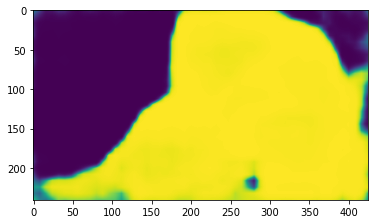

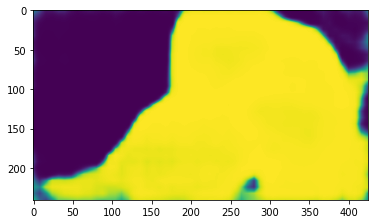

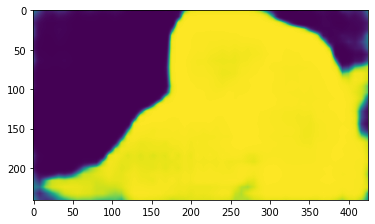

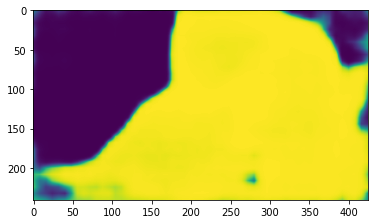

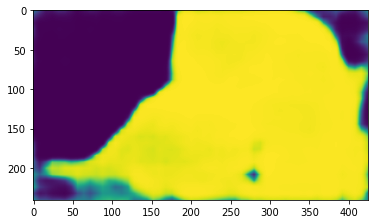

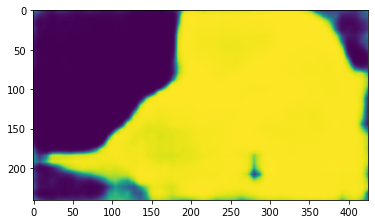

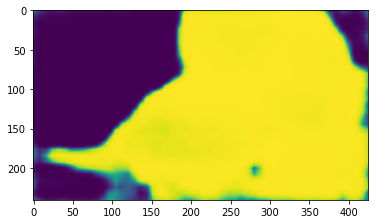

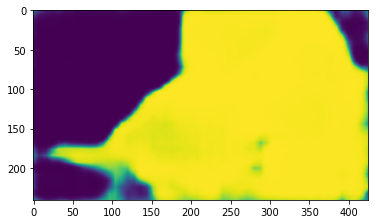

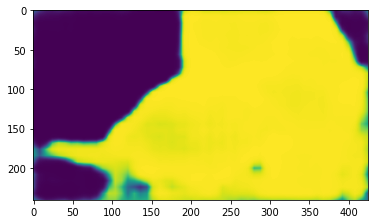

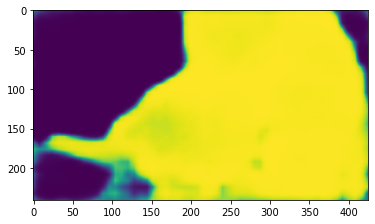

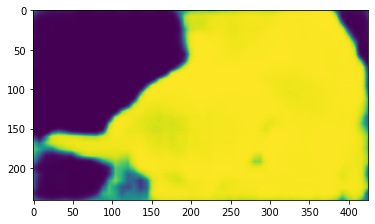

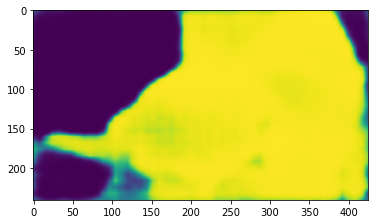

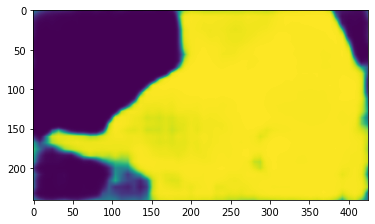

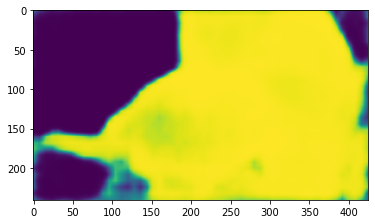

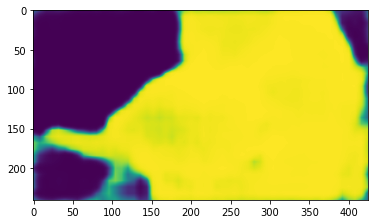

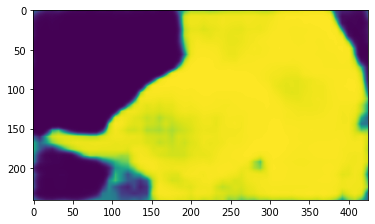

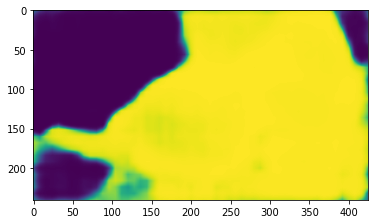

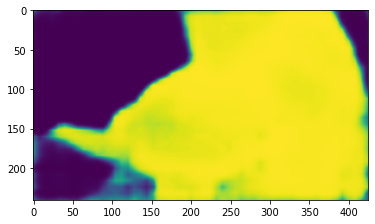

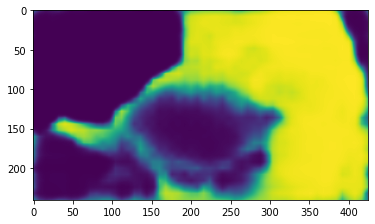

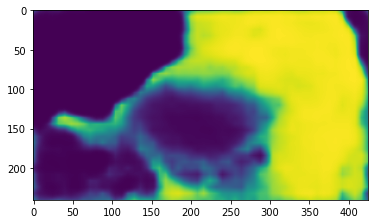

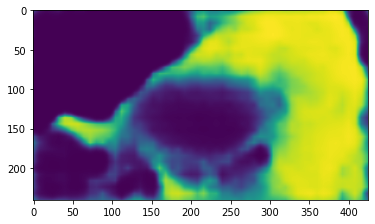

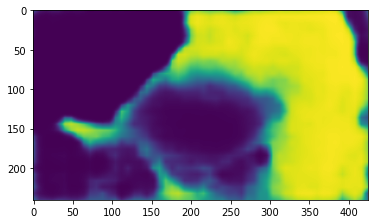

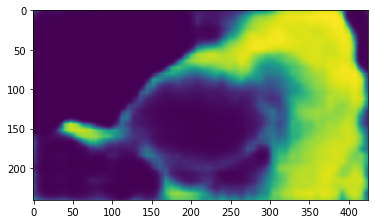

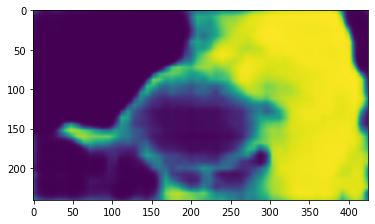

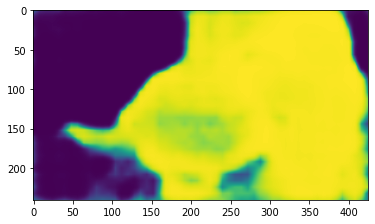

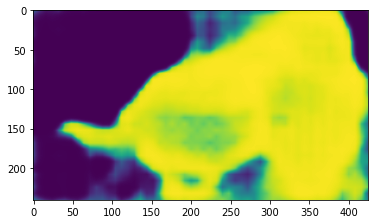

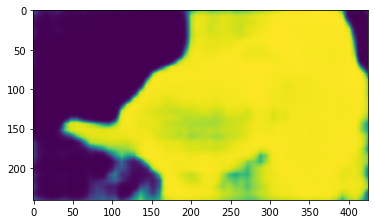

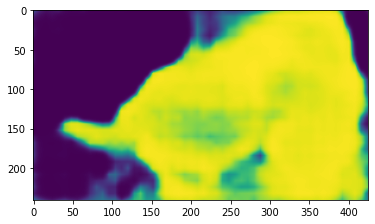

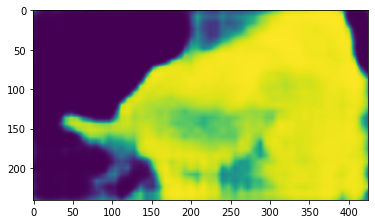

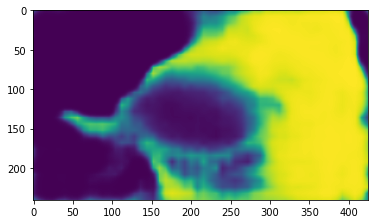

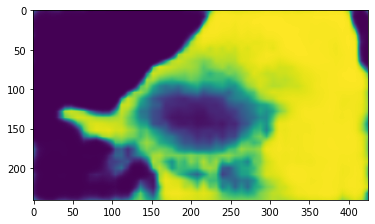

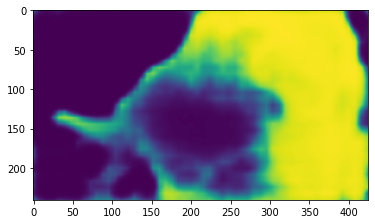

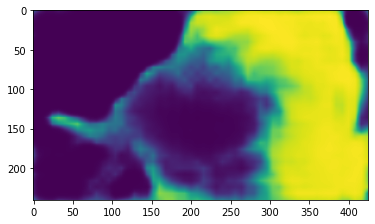

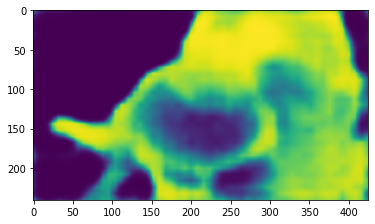

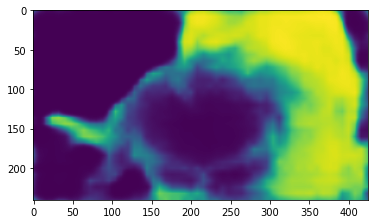

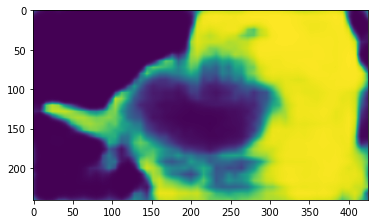

In [4]:
import numpy as np
import matplotlib.pyplot as plt
repri = np.load('/home/msiam/Code/temporal_fss/debugging_npys/repri_probas.npy')
tti = np.load('/home/msiam/Code/temporal_fss/debugging_npys/tti_probas.npy')

for i in range(0, tti.shape[0]):
    plt.figure(i)
    plt.imshow(tti[i,0,1])
    
    #plt.figure(i+1)
    #plt.imshow(repri[i//2,0,1])